In [4]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

num_epochs = 100
batch_size = 128
learning_rate = 0.001
out_dir = './autoencoder'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0,1] => [-1,1]
])
train_dataset = MNIST('./data', download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Processing...
Done!


In [6]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
if cuda:
    model.cuda()

In [7]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

loss_list = []

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        x = img.view(img.size(0), -1)
        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        loss_list.append(loss.data[0])
    
    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss.data[0]))

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))

np.save('./{}/loss_list.npy'.format(out_dir), np.array(loss_list))
torch.save(model.state_dict(), './{}/autoencoder.pth'.format(out_dir))

/Users/nakamurataiki/anaconda/envs/py35_tf/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/nakamurataiki/anaconda/envs/py35_tf/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/100], loss: 0.2079
epoch [2/100], loss: 0.1953
epoch [3/100], loss: 0.1919
epoch [4/100], loss: 0.1788
epoch [5/100], loss: 0.1674
epoch [6/100], loss: 0.1758
epoch [7/100], loss: 0.1783
epoch [8/100], loss: 0.1570
epoch [9/100], loss: 0.1652
epoch [10/100], loss: 0.1541
epoch [11/100], loss: 0.1530
epoch [12/100], loss: 0.1684
epoch [13/100], loss: 0.1565
epoch [14/100], loss: 0.1557
epoch [15/100], loss: 0.1667
epoch [16/100], loss: 0.1665
epoch [17/100], loss: 0.1566
epoch [18/100], loss: 0.1645
epoch [19/100], loss: 0.1567
epoch [20/100], loss: 0.1504
epoch [21/100], loss: 0.1454
epoch [22/100], loss: 0.1612
epoch [23/100], loss: 0.1429
epoch [24/100], loss: 0.1659
epoch [25/100], loss: 0.1541
epoch [26/100], loss: 0.1501
epoch [27/100], loss: 0.1539
epoch [28/100], loss: 0.1566
epoch [29/100], loss: 0.1410
epoch [30/100], loss: 0.1548
epoch [31/100], loss: 0.1376
epoch [32/100], loss: 0.1629
epoch [33/100], loss: 0.1398
epoch [34/100], loss: 0.1648
epoch [35/100], loss: 0

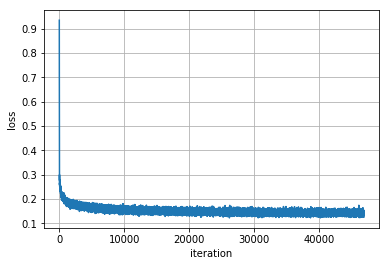

In [9]:
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()

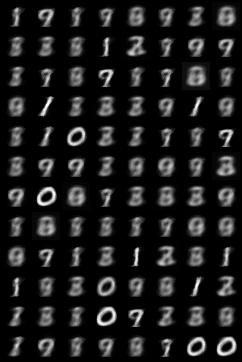

In [10]:
from IPython.display import Image
Image('autoencoder/image_0.png')

In [11]:
model.load_state_dict(torch.load('{}/autoencoder.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))

test_dataset = MNIST('./data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

images, labels = iter(test_loader).next()
images = images.view(10000, -1)

# 784次元ベクトルを2次元ベクトルにencode
z = model.encoder(Variable(images, volatile=True)).data.numpy()

/Users/nakamurataiki/anaconda/envs/py35_tf/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


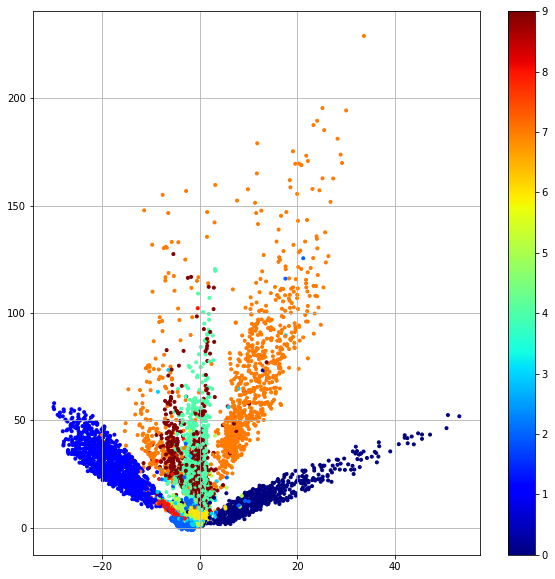

In [13]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid(True)